# Step 6: Balancing

In this step we test two different ways to balance the data and choose the best one:
* Random Undersampler
* Random Oversampler

In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Hyp. 1 - Undersample

# Pipeline Definition

In [3]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    ordered_col = ['Age range']

    categorical_cols = ['Type', 'Gender', 'Officer-defined ethnicity', 'Object of search']

    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2())
        ])
    
    # Define ordered pipeline
    ordered_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(categories=[['under 10', '10-17', '18-24', '25-34', 'over 34']] ,handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', RobustScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('ord', ordered_pipe, ordered_col),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
 

    # ros = RandomOverSampler(random_state=42)
    # X_resampled, y_resampled = ros.fit_resample(X, y)

    # smote = SMOTE(sampling_strategy='minority', random_state=42)
    # X_resampled, y_resampled = smote.fit_resample(X, y)


    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Predict

In [4]:

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.56202155 0.56319756 0.56422605 0.5612544  0.56429156]


In [5]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

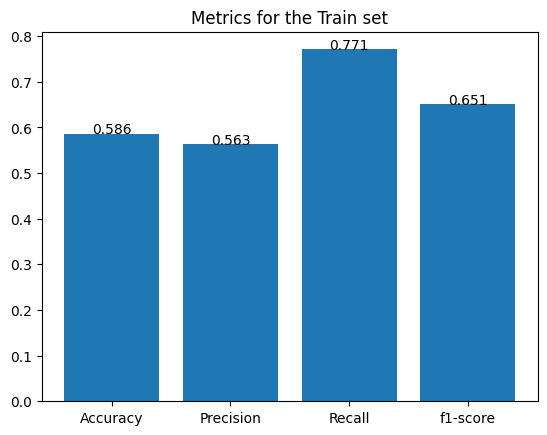

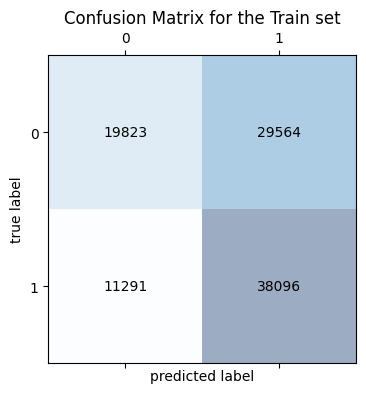

In [6]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

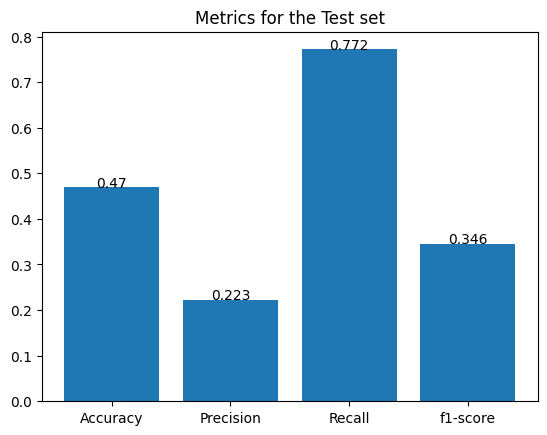

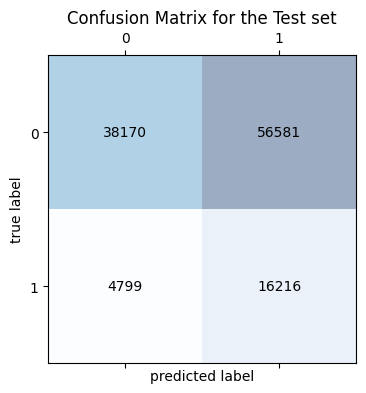

In [7]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

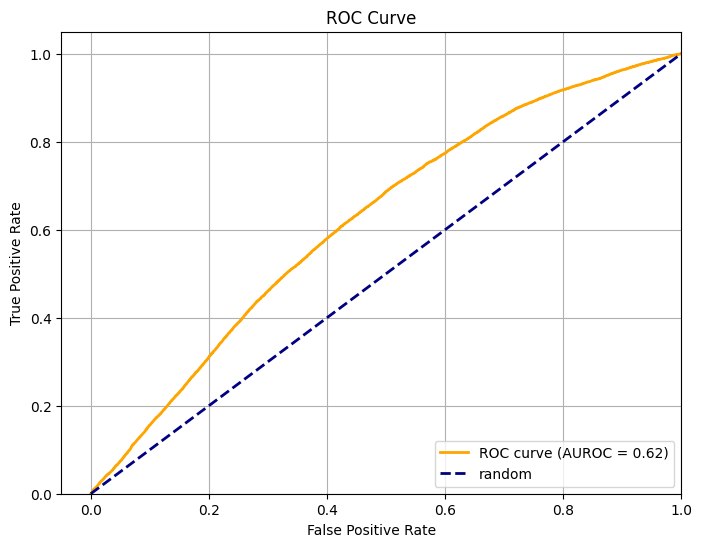

In [8]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.7716393052581489)


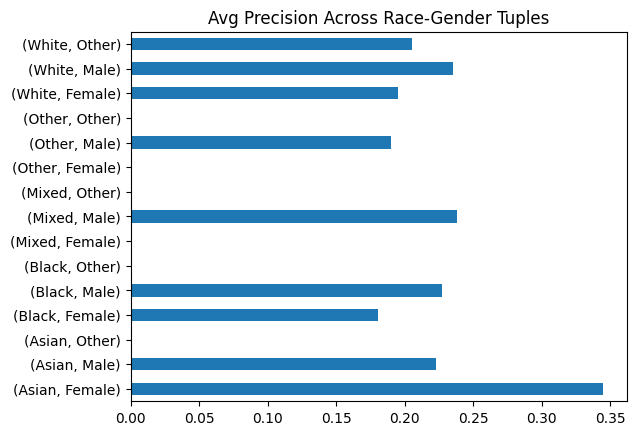

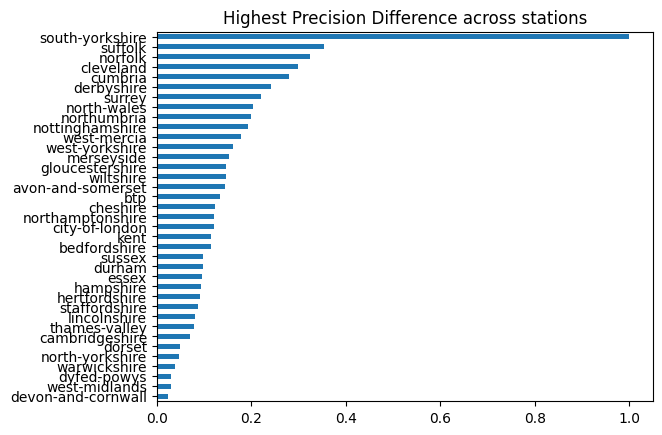

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23527259982187357, ('White', 'Female'): 0.19521240667172007, ('White', 'Other'): 0.20495495495495497, ('Black', 'Male'): 0.22691930519257575, ('Black', 'Female'): 0.18053630809048765, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.2226242221165473, ('Asian', 'Female'): 0.34472934472934474, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.23835688802291852, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.18994532734018718, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 31
Num good departments: 6
avg diff: 0.16201324324324323


In [9]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Hyp. 2 - Oversample

# Pipeline Definition

In [10]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()

    time_cols = ['Date']

    ordered_col = ['Age range']

    categorical_cols = ['Type', 'Gender', 'Officer-defined ethnicity', 'Object of search']
    # categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2())
        ])
    
    # Define ordered pipeline
    ordered_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(categories=[['under 10', '10-17', '18-24', '25-34', 'over 34']] ,handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', RobustScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('ord', ordered_pipe, ordered_col),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
 

    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # smote = SMOTE(sampling_strategy='minority', random_state=42)
    # X_resampled, y_resampled = smote.fit_resample(X, y)


    # rus = RandomUnderSampler(random_state=42)
    # X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Predict

In [11]:

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.56601896 0.56347194 0.56547954 0.56401484 0.56622761]


In [12]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

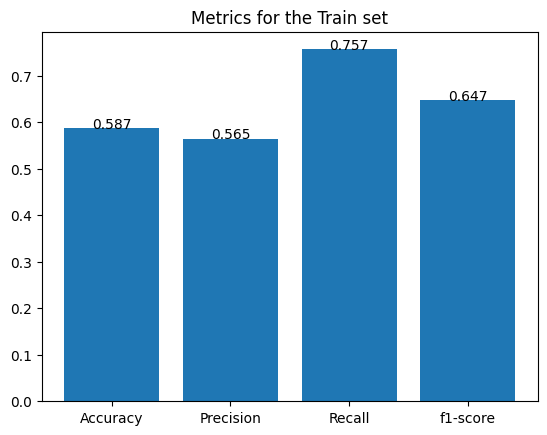

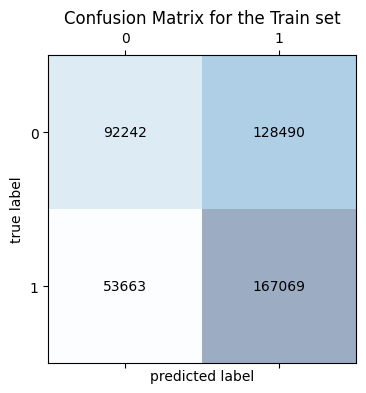

In [13]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

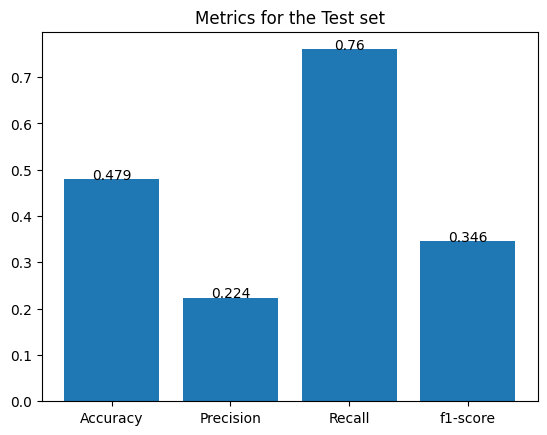

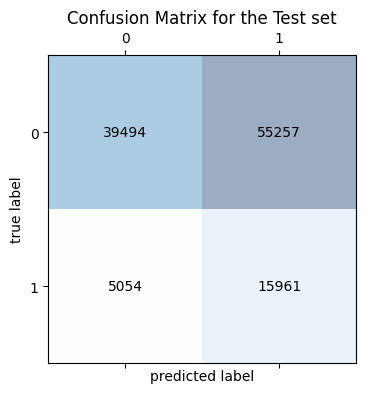

In [14]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

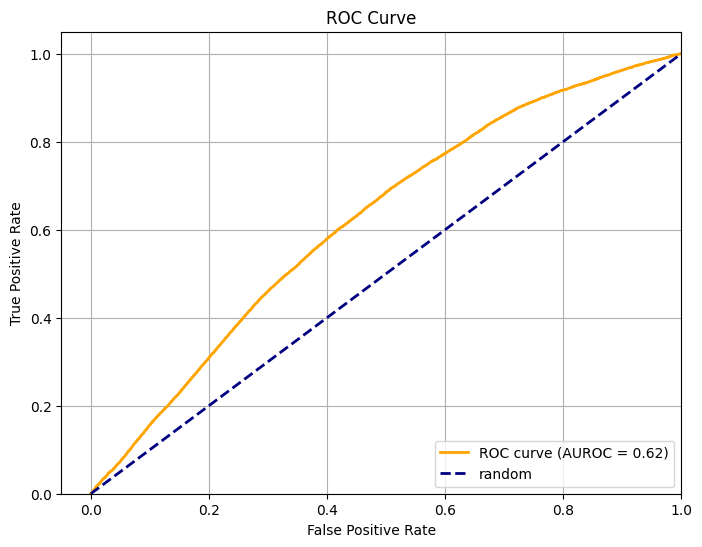

In [15]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.7595051153937663)


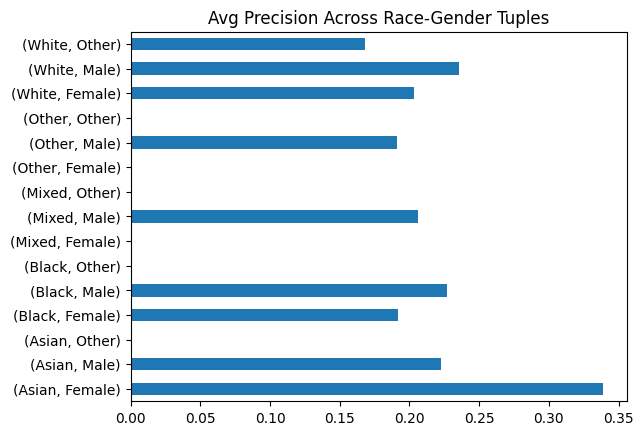

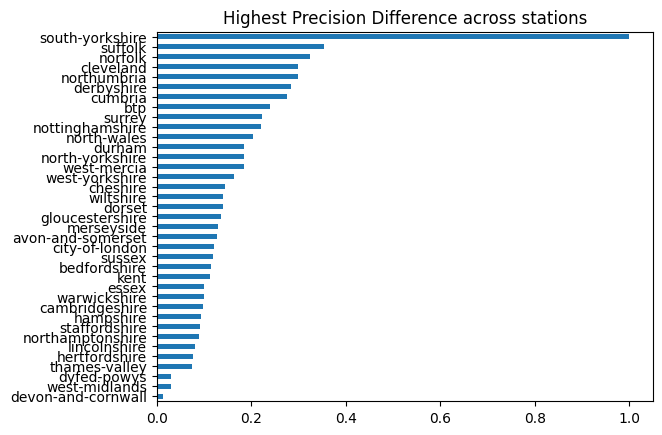

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23587749843063688, ('White', 'Female'): 0.20337134414368394, ('White', 'Other'): 0.16782407407407407, ('Black', 'Male'): 0.22710370971174712, ('Black', 'Female'): 0.19172584349054939, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.2228719817550078, ('Asian', 'Female'): 0.3389423076923077, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.20616119836112473, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.19124190726742948, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.17846135135135135


In [16]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")